# Трифонов Никита Дмитриевич  
### trifonov28rus@gmail.com  
### tg: @qwertypine

## Постановка задачи

__Цель тестового задания:__  
	Проверить как кандидат подходит к решению и решает упрощенную имитацию реальной бизнес-задачи.

__Задача:__  
	Есть описание закупки (тендера), которое нам нужно отнести к одному из классов для удобства дальнейшей работы с ним.
	 Будем считать, что сейчас есть специальные люди, которые вручную по тексту определяют к какому классу отнести эту закупку. (будем считать, что они не совершают ошибок).

	Стоимость ручной разметки одной строки = 1 рубль.
	Стоимость автоматической разметки моделью = 0 рублей.
	Стоимость ошибки модели = 2 рубля

__Данные:__   
	Во вложении архив с файлами train.csv и test.csv
	Оба файла принадлежат одному распределению и выбраны из него случайно, со стратификацией по таргету.

__Описание полей:__  
* Index – просто порядковый номер (не несет информации)
* Proc_name – описание процедуры закупки
* Target – категориальная переменная целевого класса (категория закупки).

__Результат:__  
1) Необходимо предоставить result.csv файл столбцами index, target , так чтобы столбец index соответствовал index-у из файла test.csv, а target – предсказанному значению целевого класса.  
2) Исходный код (можно jupyter notebook) с решением задачи.

__Требования к производительности:__  
	Желательно (но не обязательно), чтобы код можно было запустить локально.
	Если есть идеи, требующие больших ресурсов, но таких ресурсов нет – можно кратко описать этот подход в notebook.

__Метрики:__  
	На усмотрение кандидата.

### Подключим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from time import *
import scipy
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import seaborn as sb

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Работа с датасетом

In [2]:
train = pd.read_csv('train.csv', encoding="UTF-8", delimiter=',')

In [3]:
train

,index,proc_name,target
0,0,право заключения договора на поставку насосов ...,40
1,1,инструмент для трубопрокатных станов хпт и хпт...,31
2,2,электрооборудование каталог hahsa flex,27
3,3,оказание услуг по восстановлению работоспособн...,60
4,4,"геодезические комплектующие и аксессуары,согла...",128
...,...,...,...
212085,212085,"фрезы отрезные, шпоночные гост 2679-93, гост 5...",31
212086,212086,техническое обслуживание систем пожаротушения ...,32
212087,212087,работы по разработке проектно-сметной документ...,18
212088,212088,приобретение двс мтз- ммз 245 - 1003015б1,21


In [4]:
test = pd.read_csv('test.csv', encoding="UTF-8", delimiter=',')

In [5]:
test

,index,proc_name
0,0,подшипник 2шсл 90\r\nподшипник 2007156\r\nподш...
1,1,система лазерной защиты fiessler\r\nподробное ...
2,2,запрос услуги: перевозка металлического сетчат...
3,3,поставка насосного агрегата grundfos sv 044 (d...
4,4,"определение подрядчика на выполнение смр, пнр ..."
...,...,...
90892,90892,разработка проектно-сметной документации по об...
90893,90893,поставка шкафов телемеханики в количестве 15 ш...
90894,90894,изготовление деревянной тары с фумигацией по к...
90895,90895,"соль пищевая, помол №3.\r\nгост 51574-2000"


Text(0.5, 1.0, 'распределение меток класса')

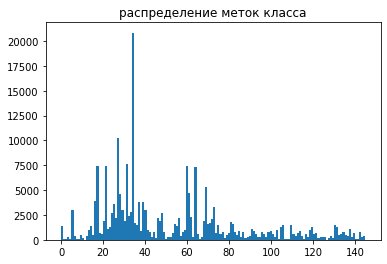

In [155]:
plt.hist(train['target'], bins = 146)
plt.title('распределение меток класса')

Выполним бинарное кодирование меток.

In [7]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
new_target = ohe.fit_transform(np.array(train['target']).reshape(-1, 1))

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
Y = new_target

In [10]:
train

,index,proc_name,target
0,0,право заключения договора на поставку насосов ...,40
1,1,инструмент для трубопрокатных станов хпт и хпт...,31
2,2,электрооборудование каталог hahsa flex,27
3,3,оказание услуг по восстановлению работоспособн...,60
4,4,"геодезические комплектующие и аксессуары,согла...",128
...,...,...,...
212085,212085,"фрезы отрезные, шпоночные гост 2679-93, гост 5...",31
212086,212086,техническое обслуживание систем пожаротушения ...,32
212087,212087,работы по разработке проектно-сметной документ...,18
212088,212088,приобретение двс мтз- ммз 245 - 1003015б1,21


## Очистка данных

In [11]:
def standardize_text(df, text_field):
    df1 = df.copy()
    
    df1[text_field] = df1[text_field].str.lower()
    #df1[text_field] = df[text_field].str.replace(r"http\S+", "")
    #df1[text_field] = df[text_field].str.replace(r"http", "")
    #df1[text_field] = df[text_field].str.replace(r"@\S+", "")
    #df1[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    #df1[text_field] = df[text_field].str.replace("\r\n", " ")
    
    df1[text_field] = df1[text_field].str.replace("[^а-яА-ЯёЁ]", " ")
    return df1


In [12]:
train = standardize_text(train, 'proc_name')

In [13]:
test = standardize_text(test, 'proc_name')

In [14]:
train['proc_name']

0         право заключения договора на поставку насосов ...
1         инструмент для трубопрокатных станов хпт и хпт...
2                    электрооборудование каталог           
3         оказание услуг по восстановлению работоспособн...
4         геодезические комплектующие и аксессуары согла...
                                ...                        
212085    фрезы отрезные  шпоночные гост          гост  ...
212086    техническое обслуживание систем пожаротушения ...
212087    работы по разработке проектно сметной документ...
212088            приобретение двс мтз  ммз              б 
212089                                 поставка провода сип
Name: proc_name, Length: 212090, dtype: object

Можем также воспользоваться лемматизацией

Нормализация

## Выберем представление для наших данных

Для этого воспользуемся One-hot encoding («Мешок слов»).

Токенизируем:

In [15]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens"] = train['proc_name'].apply(tokenizer.tokenize)
train.head()

,index,proc_name,target,tokens
0,0,право заключения договора на поставку насосов ...,40,"[право, заключения, договора, на, поставку, на..."
1,1,инструмент для трубопрокатных станов хпт и хпт...,31,"[инструмент, для, трубопрокатных, станов, хпт,..."
2,2,электрооборудование каталог,27,"[электрооборудование, каталог]"
3,3,оказание услуг по восстановлению работоспособн...,60,"[оказание, услуг, по, восстановлению, работосп..."
4,4,геодезические комплектующие и аксессуары согла...,128,"[геодезические, комплектующие, и, аксессуары, ..."


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

4189220 words total, with a vocabulary size of 89267
Max sentence length is 707


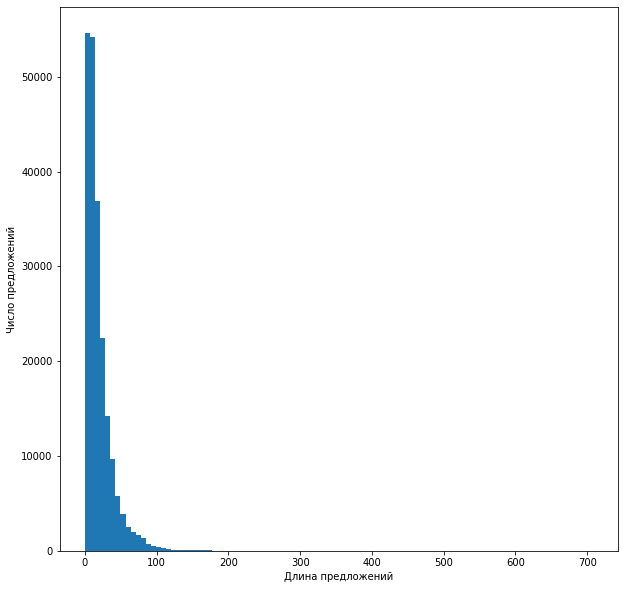

In [159]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Длина предложений')
plt.ylabel('Число предложений')
plt.hist(sentence_lengths, bins=100)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_train = (train['proc_name']).tolist()
#list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_train,
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Описанные ниже модели не смогли быть выполнены в разумное время, поэтому понизим размерность при помощи МГК.  
P.S.: На понижение размерность (например, при 10 000 компонент, ноутбук не справляется за ночь, оставим это "на потом")

In [19]:
from sklearn.decomposition import PCA 
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

def plot_variances(d_variances, i, name):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.title('Зависимость дисперсии компоненты от номера, '+str(name))
    plt.xlabel('Номер компоненты')
    plt.ylabel('Накопленная дисперсия')
    plt.legend(loc='upper right')
    #plt.savefig("/home/user/Programs/Heavy Metal/plots/"+"disp_PCA_"+str(name)+"_"+str(i)+".png", dpi=1000)
    plt.show()



def PCA_disp_components(A_X, i, name):
    data = A_X
    model = TruncatedSVD(n_components=i)
    model.fit(data)
    data = model.transform(data)
    W, L, WT = np.linalg.svd(np.dot(np.transpose(data), data))
    #print(L)
    L = (L/(sum(L)))*100
    #print(L)
    L1= np.zeros((len(L)))
    L1[0] = L[0]
    for j in range(1,len(L),1):
        L[j] = L[j] + L[j-1]
    #print(L)
    plot_variances(L, i, name)
    return 0

In [ ]:
#PCA_disp_components(X_train_counts, 500, 'X') 

In [20]:
#trnsfm = TruncatedSVD(500)
#X_train_counts_PCA = trnsfm.fit_transform(X_train_counts)

In [21]:
#X_test_counts_PCA = trnsfm.transform(X_test_counts)

In [22]:
import pandas as pd
import numpy as np
import sklearn as sk
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from time import *
from math import fabs
from scipy.stats import invgauss
import scipy
import random
import json
import math
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [178]:
# Модель на основе PCA (дает хуже результат даже на тренировочном наборе)
"""
model1 = Sequential()
model1.add(Dense(350, input_dim=(500), activation='sigmoid')) # входной слой требует задать input_dim
model1.add(Dense((len(y_train[0])), activation='linear')) # не используем функции активации
    
model1.compile(loss='mse', optimizer='adam', metrics=['acc'])

t0 = time()

history = model1.fit(X_train_counts_PCA, y_train, epochs=50, batch_size=256, verbose=1)
    
t = time()
T = t-t0
"""

"\nmodel1 = Sequential()\nmodel1.add(Dense(350, input_dim=(500), activation='sigmoid')) # входной слой требует задать input_dim\nmodel1.add(Dense((len(y_train[0])), activation='linear')) # не используем функции активации\n    \nmodel1.compile(loss='mse', optimizer='adam', metrics=['acc'])\n\nt0 = time()\n\nhistory = model1.fit(X_train_counts_PCA, y_train, epochs=50, batch_size=256, verbose=1)\n    \nt = time()\nT = t-t0\n"

In [ ]:
"""
model2 = Sequential()
model2.add(Dense(350, input_dim=(X_train_counts.shape[1]), activation='sigmoid')) # входной слой требует задать input_dim
model2.add(Dense((len(y_train[0])), activation='linear')) # не используем функции активации
    
model2.compile(loss='mse', optimizer='adam', metrics=['acc'])

t0 = time()

history = model2.fit(X_train_counts, y_train, epochs=50, batch_size=1024, verbose=1)
    
t = time()
T = t-t0
"""

## Анализ результатов 

Сначала посмотрим на распределение классов в тестовом наборе.

(array([ 276.,   16.,   12.,   63.,   13.,  596.,   68.,   25.,   21.,
          81.,   43.,    7.,   79.,  211.,  260.,   98.,  831., 1459.,
         144.,  150.,  368., 1515.,  233.,  268.,  525.,  714.,  436.,
        1967.,  937.,  617.,  402., 1586.,  478.,  563., 4235.,  332.,
         283.,  766.,  193.,  741.,  580.,  190.,  154.,   55.,  165.,
          39.,  435.,  372.,  551.,  166.,   19.,   62.,   56.,  141.,
         312.,  256.,  440.,   73.,  170.,  181., 1477.,  929.,  436.,
          50., 1463.,  126.,   19.,   57.,  388., 1009.,  291.,  336.,
         397.,  662.,  132.,  313.,  114.,  163.,   26.,  102.,  139.,
         341.,  310.,  127.,  100.,  192.,   72.,  168.,   27.,   43.,
          87.,  220.,  161.,  131.,   67.,   48.,  160.,  130.,   52.,
         163.,  170.,  103.,   50.,  206.,   20.,  253.,  295.,   20.,
          11.,   20.,  295.,  111.,   68.,  146.,  176.,   74.,   10.,
         101.,   63.,  194.,  266.,  114.,  144.,   35.,   60.,   63.,
      

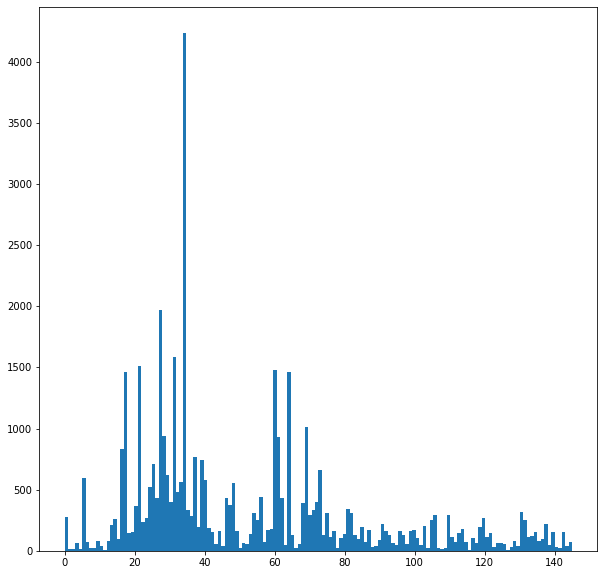

In [160]:
fig = plt.figure(figsize=(10, 10)) 
plt.hist(ohe.inverse_transform(y_test), bins=146)

Модель с PCA заметно проигрывает в точности (50% против 90% на тренировочном) модели без предобработки, поэтому будем рассматривать вторую модель.

In [25]:
model2 = load_model("model_full.h5")

In [47]:
y_predicted_classes2 = model2.predict_classes(X_test_counts)

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [161]:
target_names = range(146)
print(classification_report(ohe.inverse_transform(y_test), y_predicted_classes2))

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.74       276
         1.0       0.80      0.75      0.77        16
         2.0       0.71      0.42      0.53        12
         3.0       0.56      0.40      0.46        63
         4.0       0.61      0.85      0.71        13
         5.0       0.66      0.68      0.67       596
         6.0       0.36      0.26      0.31        68
         7.0       0.50      0.04      0.07        25
         8.0       0.38      0.24      0.29        21
         9.0       0.68      0.63      0.65        81
        10.0       0.64      0.74      0.69        43
        11.0       1.00      0.14      0.25         7
        12.0       0.33      0.14      0.20        79
        13.0       0.66      0.63      0.64       211
        14.0       0.65      0.73      0.69       260
        15.0       0.95      0.85      0.90        98
        16.0       0.78      0.74      0.76       831
        17.0       0.69    

Пусть ручная разметка этих данных стоит 1 рубль, моделью 0, а ошибка модели - 2 рубля.  
Тогда посчитаем стоимость разметки наших данных в относительные единицах:

In [175]:
cost1 = 0.22*42418*2 #42418 - число объектов в нашем датасете, заменим это на относительную стоимость, т.е. на 1
print(cost1)

18663.920000000002


Стоимость ручной разметки наших данных - 1.

А что если часть данных, которую мы с трудом предсказываем, помечать руками?  
Посчитаем вероятности для каждого класса:

In [32]:
pred_scr = model2.predict_proba(X_test_counts)

/home/user/anaconda3/lib/python3.7/site-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


Рассмотрим вероятности и сделаем отсечку по самым минимальным.

In [169]:
max_prob = np.max(pred_scr, axis=1) #максимальная вероятность для каждого классса

Отсечем 20% по квантилю строк с самыми низкими вероятностями.

In [170]:
np.quantile(max_prob, 0.2)

0.4478765785694122

Индексы строк, удовлетворяющие нашим условиям (верятность больше 0.45):

In [136]:
ind = np.where(pred_scr > np.quantile(max_prob, 0.2))[0]

In [137]:
len(ind)

36530

In [164]:
y_test.shape

(42418, 146)

Тогда вручную придется разметить строк:

In [171]:
42418 - 36530

5888

При этом точность повысилась:

In [138]:
acc_clear = accuracy_score(ohe.inverse_transform(y_test)[ind], y_predicted_classes[ind])
print(acc_clear)

0.8338625787024364


Тогда итоговая стоимость модели:

In [174]:
cost2 = 0.16*36530*2 + 5888*1
print(cost2)

17577.6


In [176]:
print('Стоимость первой модели:', cost1)
print('Стоимость второй модели:', cost2)

Стоимость первой модели: 18663.920000000002
Стоимость второй модели: 17577.6


Как видим, вторая модель оказалась выгоднее.

## Критика и дальнейшая работа

#### Данные:  
* Нормализация (Стемминг/Лематизация);
* Выделить коллокации различными методами;
* Можно удалить самые редкие/частые слова;
* Произвести разведочный анализ: корреляция, самые значимые слова и т.д.
* Извлечение признаков из текста:  
  * TF-IDF;  
  * N-граммы;
  * Буквенные n-граммы;
  * Skip-граммы;  
  * Хэширование;
  * МГК;
  * ___Word2vec___;
  * Рассмотрение предложения как последовательности индивидуальных векторов слов с использованием или Word2Vec, или более свежих подходов вроде GloVe или CoVe.


#### Модели:  
* Стоит лучше провалидировать модели (например, валидационный набор при обучении или кросс-валидация);
* Callbacks, критерии остановки для обучения, сохранение лучшей модели;
* Построить более простые модели и убедиться, что вы интерпретируете информацию, а не шум;
* Попробовать иные модели глубокого обучения:
  * RNN;
  * CNN;
  * LSTM;
  * GRU;
  * biderectional RNN;
* Слой Embedding, прореживание и др.;
* Перебор гиперпараметров;  
* Последние научные статьи по теме NLP (прим.: https://arxiv.org/abs/1408.5882);


#### Анализ результатов:  
* LIME (есть на GitHub) - позволяет интерпретировать результаты любого классификатора;
* Составить более общую формулу для рассчета стоимости.


## Предскажем результат для тестовой выборки

In [182]:
list_test = (test['proc_name']).tolist()

In [183]:
test_counts = count_vectorizer.transform(list_test)

In [184]:
test_predicted_classes2 = model2.predict_classes(test_counts)

In [188]:
len(test_predicted_classes2)

90897

In [187]:
test

,index,proc_name
0,0,подшипник шсл подшипник подшипни...
1,1,система лазерной защиты подробное оп...
2,2,запрос услуги перевозка металлического сетчат...
3,3,поставка насосного агрегата ...
4,4,определение подрядчика на выполнение смр пнр ...
...,...,...
90892,90892,разработка проектно сметной документации по об...
90893,90893,поставка шкафов телемеханики в количестве ш...
90894,90894,изготовление деревянной тары с фумигацией по к...
90895,90895,соль пищевая помол гост


In [189]:
res_df = test.copy()

In [190]:
res_df

,index,proc_name
0,0,подшипник шсл подшипник подшипни...
1,1,система лазерной защиты подробное оп...
2,2,запрос услуги перевозка металлического сетчат...
3,3,поставка насосного агрегата ...
4,4,определение подрядчика на выполнение смр пнр ...
...,...,...
90892,90892,разработка проектно сметной документации по об...
90893,90893,поставка шкафов телемеханики в количестве ш...
90894,90894,изготовление деревянной тары с фумигацией по к...
90895,90895,соль пищевая помол гост


In [191]:
del res_df['proc_name']

In [194]:
res_df['target'] = test_predicted_classes2

In [195]:
res_df

,index,target
0,0,36
1,1,54
2,2,39
3,3,40
4,4,34
...,...,...
90892,90892,19
90893,90893,33
90894,90894,68
90895,90895,46


In [196]:
np.savetxt('result.csv', res_df)